In [6]:
import nibabel                      as nib
import nibabel.freesurfer.mghformat as mgh
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [7]:
from scipy import ndimage
from sklearn.preprocessing import minmax_scale

def read_mgz_file(filepath):
    """Read and load volume"""
    # Read file
    scan = mgh.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def convertersize(volume):
    """convertersize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 256
    desired_width = 256
    desired_height = 256
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 270, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def crop_image(img):
    # Find first and last slices that contain parts of the brain
    blank = img[0].sum()
    x = []
    for i in range(len(img)):
        if img[i,:,:].sum() != blank:
            x.append(i)
    y = []
    for i in range(len(img)):
        if img[:,i,:].sum() != blank:
            y.append(i)
    z = []
    for i in range(len(img)):
        if img[:,:,i].sum() != blank:
            z.append(i)
    # Use these to crop the 3D images
    img = np.squeeze(img[min(x):max(x), min(y):max(y), min(z):max(z)])
    
    # Set the desired depth
    desired_depth = 128
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
#     # Greyscale normalization
#     img = img/(img.max()/255.0)
#     img = img - 255
#     img = abs(img)
#     img = img/(img.max()/255.0)
#     img = abs(img-255)
    return img

def create_patches(img):
    patches=[]
    for i in [0,32,64]:
        for j in [0,32,64]:
            for k in [0,32,64]:
                patch = np.squeeze(img[i:(i+64), j:(j+64), k:(k+64)])
                # Greyscale normalization
                patch = patch/(patch.max()/255.0)
                patch = patch - 255
                patch = abs(patch)
                patch = patch/(patch.max()/255.0)
                patch = abs(patch-255)
                patches.append(patch)
    return patches

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_mgz_file(path)
    #  convertersize
    volume = convertersize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    # Crop 3D image
    volume = crop_image(volume)
    # Create patches
    volume = create_patches(volume)
    return volume

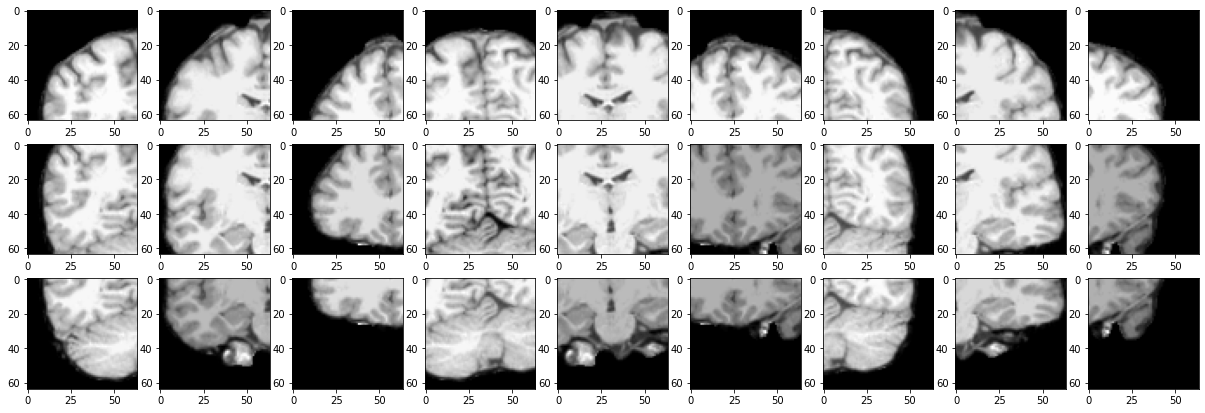

In [4]:
patches = process_scan('Scans_CN/OAS30005_MR_d0143.mgz')
fig = plt.figure(figsize=(21, 7))
columns = 9
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(patches[i-1][:, :, 32]), cmap="gray")
plt.show()

## Reading data

In [8]:
# Folder "Scans_CN" consist of subjects who remained cognitively converters for the whole study.
CN_scan_paths = [
    os.path.join(os.getcwd(), "Scans_CN", x)
    for x in os.listdir("Scans_CN")
]
# Folder "Scans_Converters" consist of subjects who converted from CN to MCI > 0.
converters_scan_paths = [
    os.path.join(os.getcwd(), "Scans_Converters", x)
    for x in os.listdir("Scans_Converters")
]

print("MRI scans for patients remaining CN: " + str(len(CN_scan_paths)))
print("MRI scans for patients converting to AD: " + str(len(converters_scan_paths)))

MRI scans for patients remaining CN: 154
MRI scans for patients converting to AD: 50


In [6]:
for i in range(2,27):
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


Epoch 1/1000
4/4 - 35s - loss: 0.6912 - acc: 0.5250 - auc: 0.5347 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 2/1000
4/4 - 2s - loss: 0.6797 - acc: 0.6125 - auc: 0.5741 - val_loss: 0.6958 - val_acc: 0.5000 - val_auc: 0.4000
Epoch 3/1000
4/4 - 2s - loss: 0.6564 - acc: 0.6250 - auc: 0.6813 - val_loss: 0.6946 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 4/1000
4/4 - 2s - loss: 0.6444 - acc: 0.6375 - auc: 0.7034 - val_loss: 0.7079 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 5/1000
4/4 - 2s - loss: 0.5939 - acc: 0.7250 - auc: 0.7450 - val_loss: 0.7183 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 6/1000
4/4 - 2s - loss: 0.5662 - acc: 0.7250 - auc: 0.7887 - val_loss: 0.7327 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 7/1000
4/4 - 2s - loss: 0.4616 - acc: 0.8125 - auc: 0.8628 - val_loss: 0.7403 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 8/1000
4/4 - 2s - loss: 0.6233 - acc: 0.7000 - auc: 0.7438 - val_loss: 0.7726 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 9/1000
4/4 - 2s - loss: 0.5200 - 

C:\Users\Justin\AppData\Local\Temp/ipykernel_2420/979232400.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(20, 3))


Epoch 1/1000
4/4 - 26s - loss: 0.6918 - acc: 0.5125 - auc_21: 0.5075 - val_loss: 0.6910 - val_acc: 0.5000 - val_auc_21: 0.6600
Epoch 2/1000
4/4 - 2s - loss: 0.6656 - acc: 0.6250 - auc_21: 0.6728 - val_loss: 0.7105 - val_acc: 0.5000 - val_auc_21: 0.3250
Epoch 3/1000
4/4 - 2s - loss: 0.6700 - acc: 0.5625 - auc_21: 0.6344 - val_loss: 0.8113 - val_acc: 0.5000 - val_auc_21: 0.3250
Epoch 4/1000
4/4 - 2s - loss: 0.7094 - acc: 0.5125 - auc_21: 0.5847 - val_loss: 0.7448 - val_acc: 0.5000 - val_auc_21: 0.5000
Epoch 5/1000
4/4 - 2s - loss: 0.6537 - acc: 0.6250 - auc_21: 0.6509 - val_loss: 0.7323 - val_acc: 0.5000 - val_auc_21: 0.5000
Epoch 6/1000
4/4 - 2s - loss: 0.6502 - acc: 0.6000 - auc_21: 0.6750 - val_loss: 0.7751 - val_acc: 0.5000 - val_auc_21: 0.5000
Epoch 7/1000
4/4 - 2s - loss: 0.6214 - acc: 0.5875 - auc_21: 0.7856 - val_loss: 0.8173 - val_acc: 0.5000 - val_auc_21: 0.5000
Epoch 8/1000
4/4 - 2s - loss: 0.6085 - acc: 0.7125 - auc_21: 0.7387 - val_loss: 0.9062 - val_acc: 0.5000 - val_auc_21

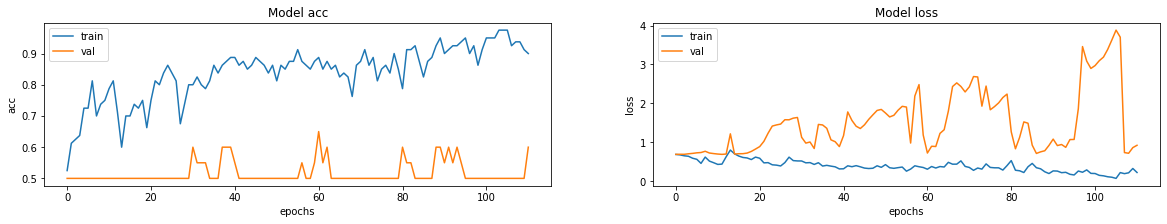

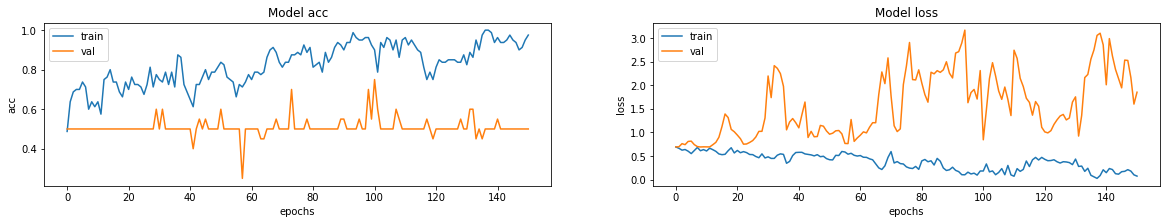

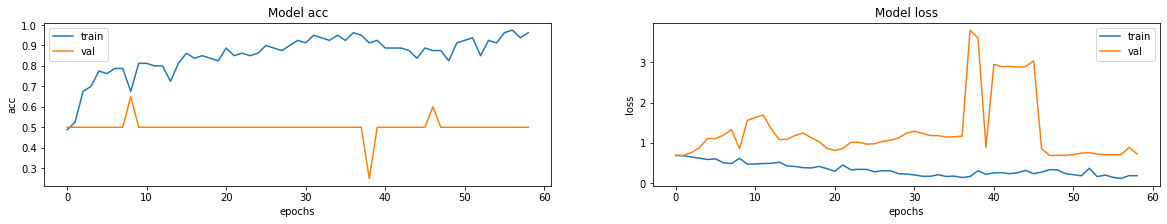

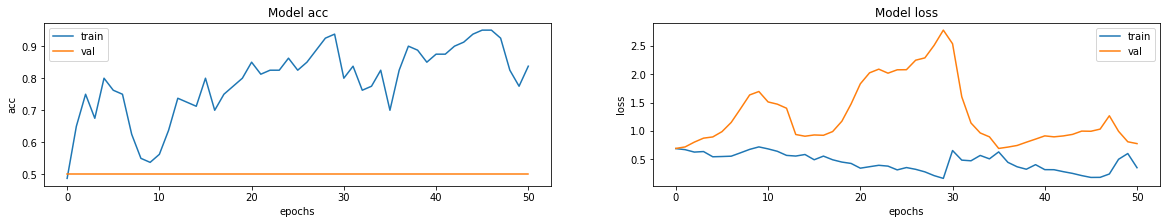

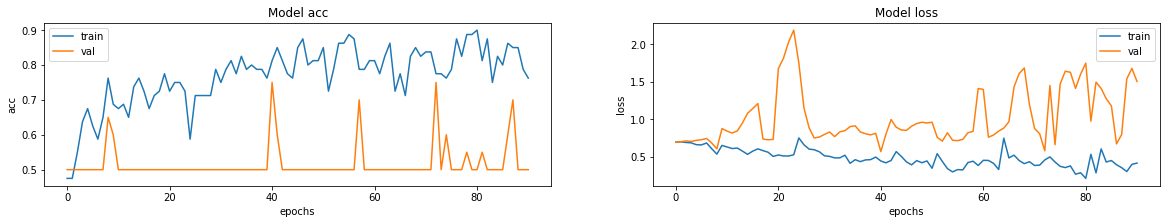

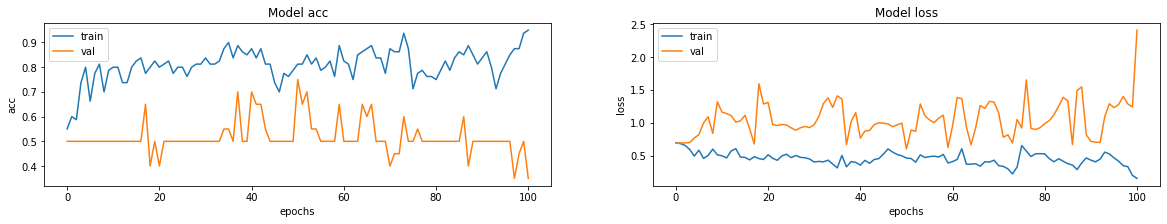

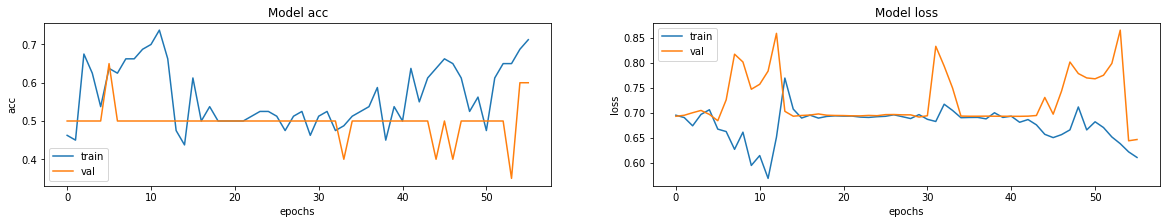

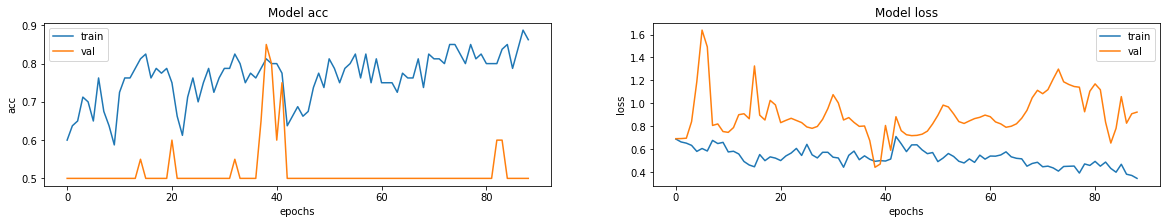

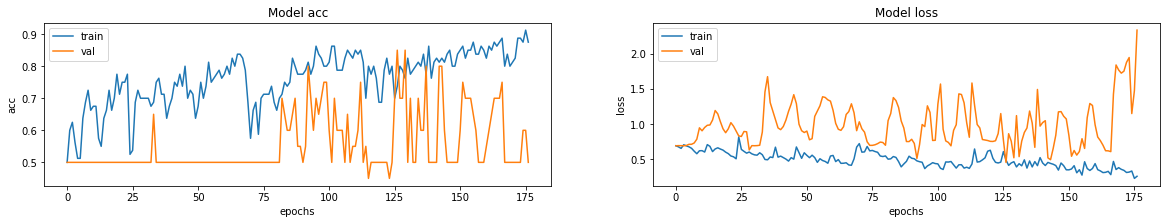

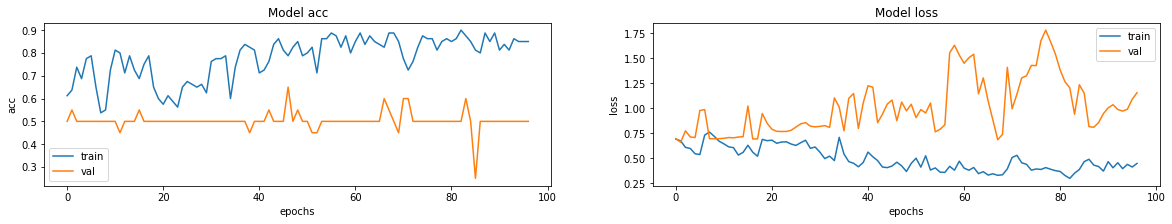

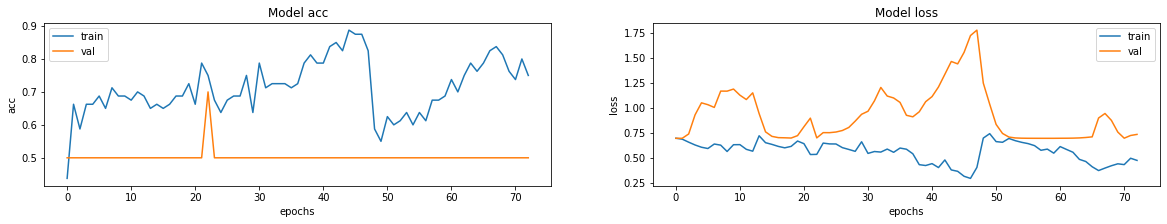

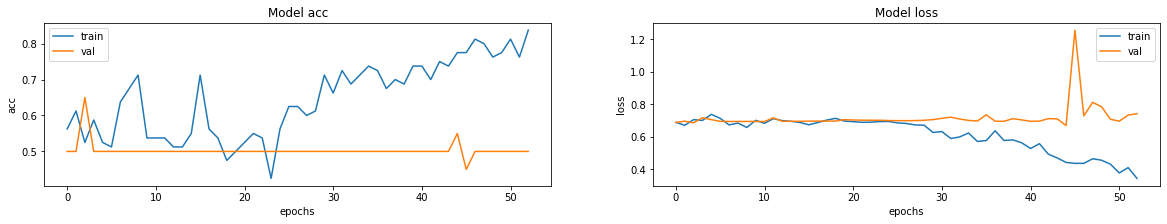

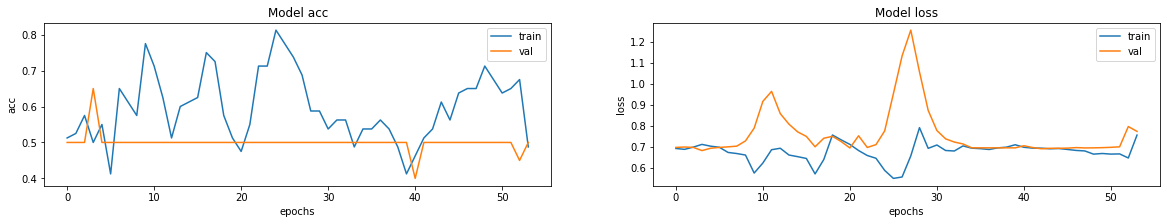

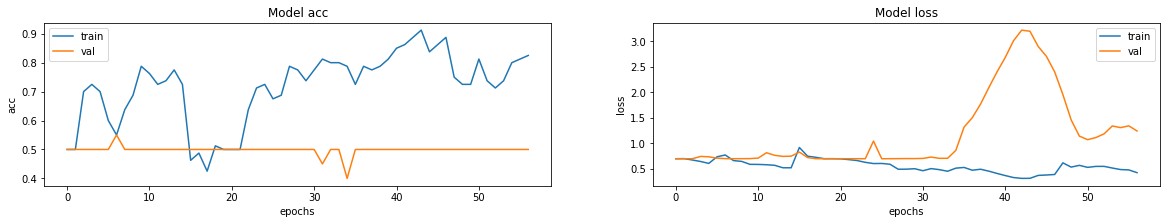

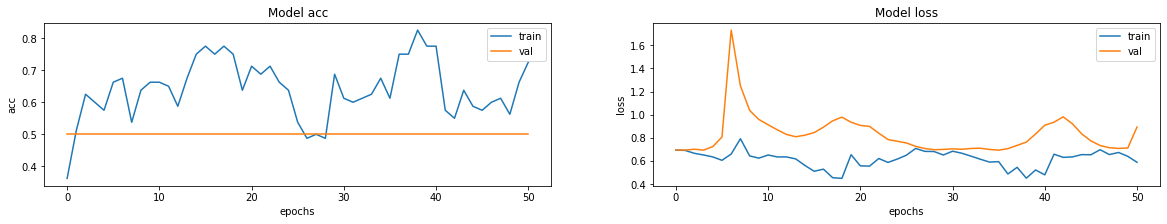

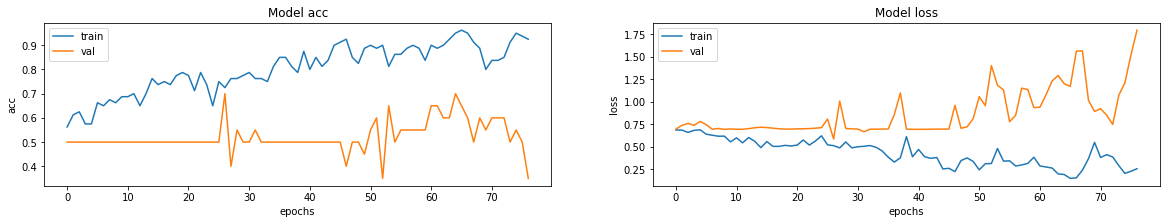

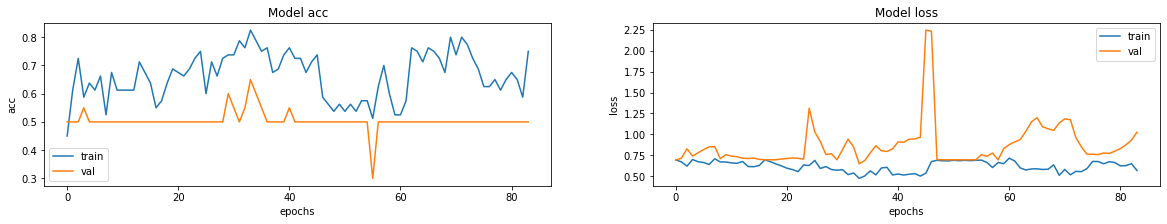

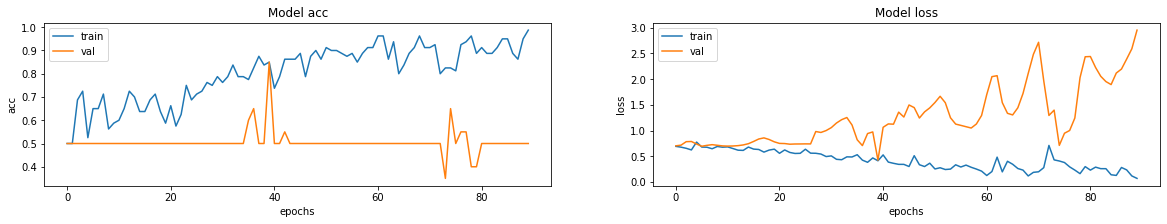

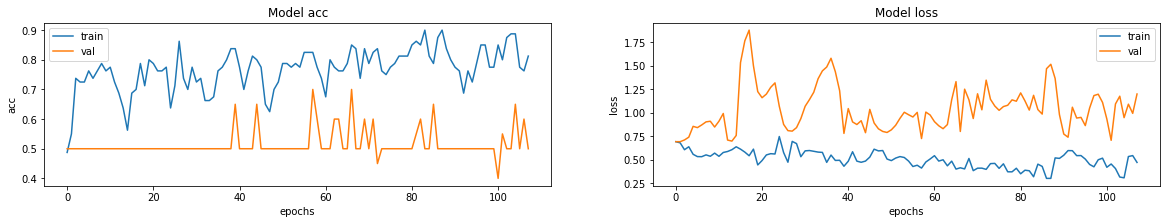

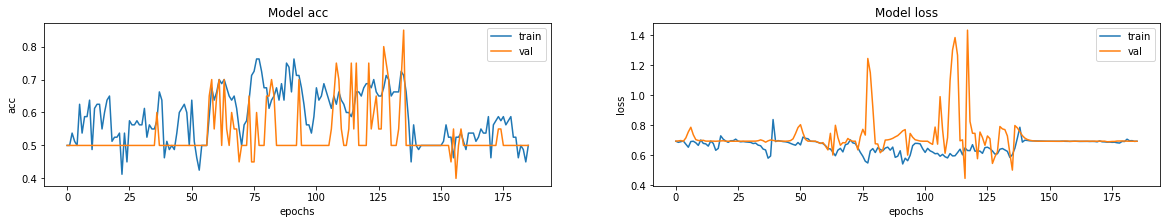

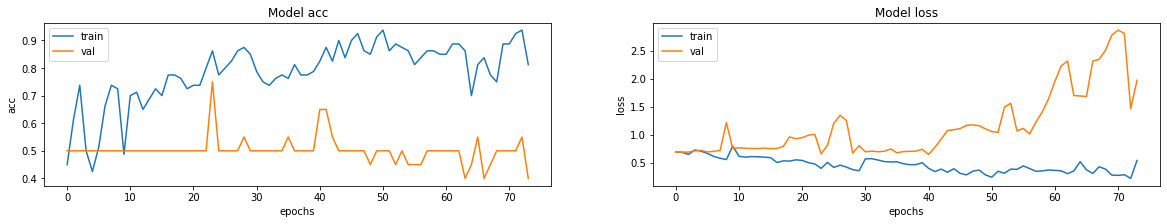

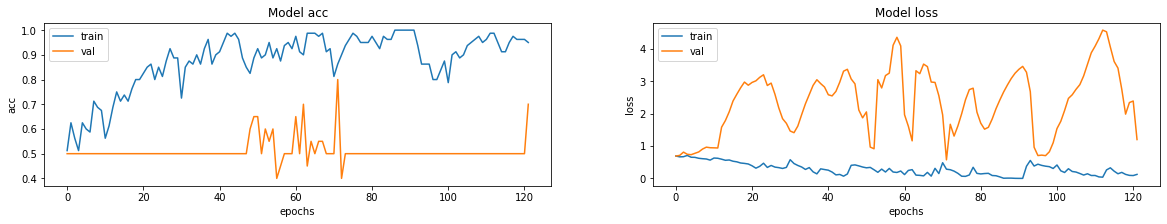

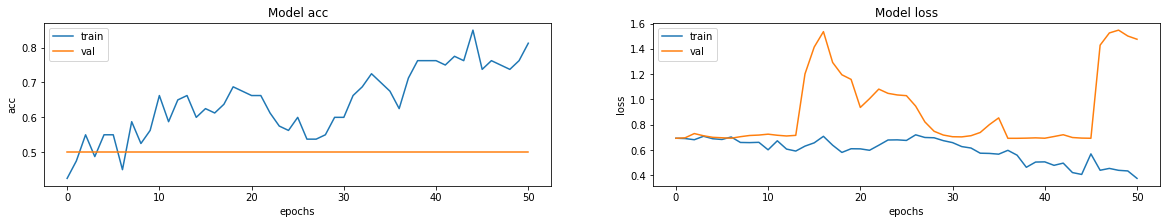

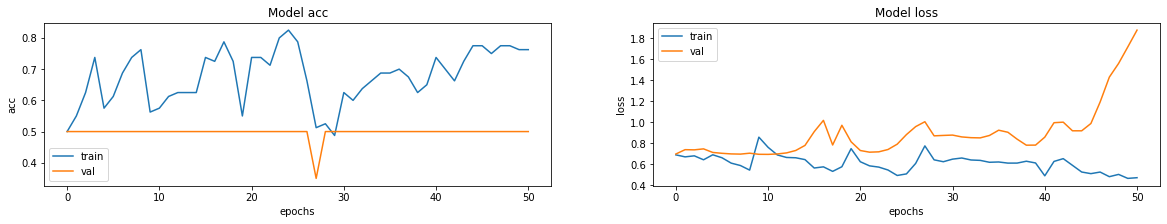

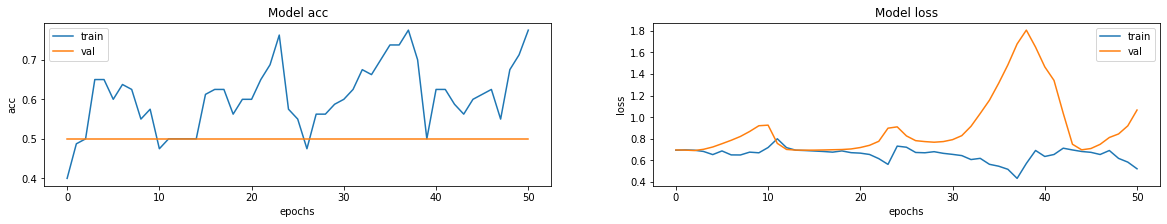

In [7]:
# for i in range(27):
for i in range(2, 27):
    # Read and process the scans.
    # Each scan is resized across height, width, and depth and rescaled.
    CN_scans = np.array([process_scan(path)[i] for path in CN_scan_paths])
    converters_scans = np.array([process_scan(path)[i] for path in converters_scan_paths])

    # For the converters assign 1, for the CN subjects assign 0.
    CN_labels = np.array([0 for _ in range(len(CN_scans))])
    converters_labels = np.array([1 for _ in range(len(converters_scans))])


    # Randomly select samples from CN to create even 50/50 split
    select = np.random.choice(len(CN_scans),len(converters_scans), replace=False)
    CN_scans = CN_scans[select]
    CN_labels = CN_labels[select]

    # Create another random split for selection
    select = np.random.choice(len(CN_scans),len(converters_scans), replace=False)
    # Split data in the ratio 80-20 for training and validation.
    x_train = np.concatenate((CN_scans[select[:40]], converters_scans[select[:40]]), axis=0)
    y_train = np.concatenate((CN_labels[select[:40]], converters_labels[select[:40]]), axis=0)
    x_val = np.concatenate((CN_scans[select[40:]], converters_scans[select[40:]]), axis=0)
    y_val = np.concatenate((CN_labels[select[40:]], converters_labels[select[40:]]), axis=0)

    x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
    x_val_rgb = np.repeat(x_val[..., np.newaxis], 3, -1)

    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val_rgb, y_val))

    batch_size = 20
    # Augment the on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(x_train_rgb))
        .batch(batch_size)
        .prefetch(1)
    )
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(x_val_rgb))
        .batch(batch_size)
        .prefetch(1)
    )

    # for tensorflow.keras
    from classification_models_3D.tfkeras import Classifiers

    DenseNet121, preprocess_input = Classifiers.get('densenet121')
    base_model = DenseNet121(input_shape=(64, 64, 64, 3), weights='imagenet')

    x = base_model.output
    # x = tf.keras.layers.Dense(1024,activation='relu')(x) 
    x = tf.keras.layers.Dense(1000,activation='relu')(x) 
    x = tf.keras.layers.Dense(500,activation='relu')(x)
    x = tf.keras.layers.Dense(200,activation='relu')(x) 
    x = tf.keras.layers.Dense(1, activation= 'sigmoid')(x)
    model = keras.Model(inputs = base_model.input, outputs = x)



    auc = tf.keras.metrics.AUC()  # instantiate it here to have a shorter handle

    # # Compile model.
    # initial_learning_rate = 0.001
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
    # )
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["acc", auc],
    )

    # Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        str("DenseNet121/3d_image_classification"+str(i)+".h5"), save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50)

    # Train the model, doing validation at the end of each epoch
    epochs = 1000
    model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_cb, early_stopping_cb],
    )

    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, metric in enumerate(["acc", "loss"]):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

In [8]:
cnt=0
for i in range(20):
    # Load best weights.
    model.load_weights("DenseNet121/3d_image_classification1.h5")
    prediction = model.predict(np.expand_dims(x_val_rgb[i], axis=0))[0]
    print(prediction)
    if round(prediction[0])==y_val[i]:
        cnt+=1
print(cnt/20)

[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
[0.8575872]
0.5


In [9]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve (y_val, y_val_cat_prob)

NameError: name 'y_val_cat_prob' is not defined

In [ ]:
model.load_weights("DenseNet121/3d_image_classification1.h5")
prediction = model.predict(np.expand_dims(x_val_rgb[1], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]


In [ ]:
model.load_weights("DenseNet121/3d_image_classification1.h5")

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
y_val_cat_prob=model.predict(x_val_rgb)
fpr, tpr, thresholds = roc_curve(y_val, y_val_cat_prob)
def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

auc_score=roc_auc_score(y_val,y_val_cat_prob)
print(auc_score)
plot_roc_curve(fpr,tpr) 

In [9]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
CN_scans = np.array([process_scan(path)[i] for path in CN_scan_paths])
converters_scans = np.array([process_scan(path)[i] for path in converters_scan_paths])

# For the converters assign 1, for the CN subjects assign 0.
CN_labels = np.array([0 for _ in range(len(CN_scans))])
converters_labels = np.array([1 for _ in range(len(converters_scans))])


# Randomly select samples from CN to create even 50/50 split
select = np.random.choice(len(CN_scans),len(converters_scans), replace=False)
CN_scans = CN_scans[select]
CN_labels = CN_labels[select]

# Create another random split for selection
select = np.random.choice(len(CN_scans),len(converters_scans), replace=False)
# Split data in the ratio 80-20 for training and validation.
x_train = np.concatenate((CN_scans[select[:40]], converters_scans[select[:40]]), axis=0)
y_train = np.concatenate((CN_labels[select[:40]], converters_labels[select[:40]]), axis=0)
x_val = np.concatenate((CN_scans[select[40:]], converters_scans[select[40:]]), axis=0)
y_val = np.concatenate((CN_labels[select[40:]], converters_labels[select[40:]]), axis=0)

x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
x_val_rgb = np.repeat(x_val[..., np.newaxis], 3, -1)

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val_rgb, y_val))

batch_size = 20
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train_rgb))
    .batch(batch_size)
    .prefetch(1)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val_rgb))
    .batch(batch_size)
    .prefetch(1)
)


KeyboardInterrupt: 

In [ ]:
# for tensorflow.keras
from classification_models_3D.tfkeras import Classifiers

DenseNet121, preprocess_input = Classifiers.get('densenet121')
base_model = DenseNet121(input_shape=(64, 64, 64, 3), weights='imagenet')

x = base_model.output
# x = tf.keras.layers.Dense(1024,activation='relu')(x) 
x = tf.keras.layers.Dense(1000,activation='relu')(x) 
x = tf.keras.layers.Dense(500,activation='relu')(x)
x = tf.keras.layers.Dense(200,activation='relu')(x) 
x = tf.keras.layers.Dense(1, activation= 'sigmoid')(x)
model = keras.Model(inputs = base_model.input, outputs = x)



auc = tf.keras.metrics.AUC()  # instantiate it here to have a shorter handle

# # Compile model.
# initial_learning_rate = 0.001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
# )
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["acc", auc],
)

In [ ]:
def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    
    cnt=0
for i in range(27):
    # Load best weights.
    model.load_weights(str("DenseNet121/3d_image_classification"+str(i)+".h5"))
    from sklearn.metrics import roc_curve,roc_auc_score
    y_val_cat_prob=model.predict(x_val_rgb)
    fpr, tpr, thresholds = roc_curve(y_val, y_val_cat_prob)
    auc_score=roc_auc_score(y_val,y_val_cat_prob)
    print(auc_score)
    plot_roc_curve(fpr,tpr) 


In [ ]:
 checkpoint_cb = keras.callbacks.ModelCheckpoint(
        str("DenseNet121/3d_image_classification"+str(i)+".h5"), 